In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

In [4]:
data = yf.download('ADA-USD', start='2022-06-15', end='2023-06-15')

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-15,0.484160,0.536792,0.450104,0.533296,0.533296,2335125416
2022-06-16,0.533529,0.544017,0.469018,0.475022,0.475022,1226235066
2022-06-17,0.475183,0.502739,0.473478,0.487392,0.487392,872710309
2022-06-18,0.487367,0.494669,0.423419,0.456182,0.456182,1214101657
2022-06-19,0.455970,0.487226,0.437213,0.484364,0.484364,1050008285


In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-10,0.295378,0.295378,0.230420,0.276194,0.276194,1293643754
2023-06-11,0.276047,0.279404,0.260312,0.272630,0.272630,507820127
2023-06-12,0.272583,0.285934,0.266694,0.275048,0.275048,431423925
2023-06-13,0.275054,0.287422,0.269893,0.274986,0.274986,319427367
2023-06-14,0.274990,0.276916,0.258221,0.263226,0.263226,244895035


In [7]:
Ri_1 = data['Adj Close'] # I have created a new data value for less months range
Ri_1.tail()

Date
2023-06-10    0.276194
2023-06-11    0.272630
2023-06-12    0.275048
2023-06-13    0.274986
2023-06-14    0.263226
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

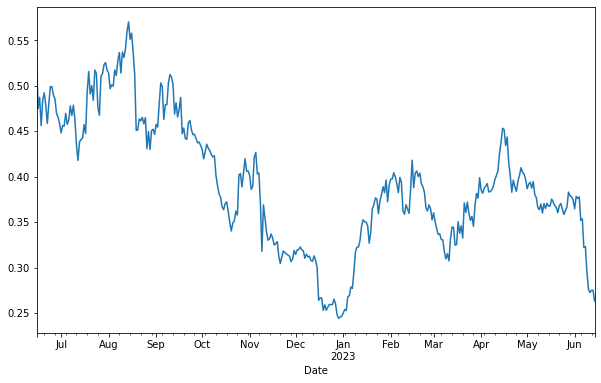

In [8]:
Ri_1.plot(figsize=(10, 6), subplots=True)

In [9]:
ADAMin = Ri_1[-92:-1] # Here a new value shows 3 months price of Cardano, there i have used *92-1
ADAMin

Date
2023-03-15    0.324637
2023-03-16    0.325383
2023-03-17    0.350524
2023-03-18    0.337711
2023-03-19    0.346010
                ...   
2023-06-09    0.295401
2023-06-10    0.276194
2023-06-11    0.272630
2023-06-12    0.275048
2023-06-13    0.274986
Name: Adj Close, Length: 91, dtype: float64

In [10]:
log_return = np.log(ADAMin / ADAMin.shift(1)) # I have used Log return of 3 months because it is symmetric and used for Volatility financial calculation. 
log_return

Date
2023-03-15         NaN
2023-03-16    0.002295
2023-03-17    0.074426
2023-03-18   -0.037239
2023-03-19    0.024277
                ...   
2023-06-09   -0.089805
2023-06-10   -0.067230
2023-06-11   -0.012988
2023-06-12    0.008830
2023-06-13   -0.000225
Name: Adj Close, Length: 91, dtype: float64

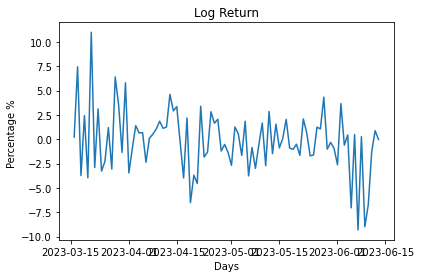

In [11]:
fig = plt.figure()
plt.plot(log_return * 100)
plt.xlabel('Days')
plt.ylabel('Percentage % ')
plt.title('Log Return');

In [12]:
vol = np.sqrt(252) * log_return.std() # I have changed the days value to 252 to calculate annual volatility
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 51.48 %


In [13]:
S0 = ADAMin[-1]      #Here i have calculated my recent spot price
S0

0.27498599886894226


# Monte Carlo 

In [14]:
S = S0                  # spot price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.5/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [15]:
def mcs_simulation_np(m,n):       #m is the number of steps and n is the number of simulation
    M = m
    I = n
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [16]:
S = mcs_simulation_np(90,10000)

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

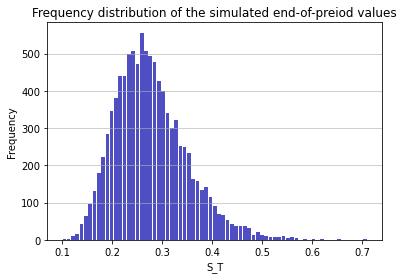

In [17]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[-1,:], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [18]:
p = np.mean(np.maximum(S[-1,:] - K,0))
print('European call', str(p))

European call 0.0004597765555705891


# Black Scholes 

In [19]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [20]:
bsp = euro_option_bs(S0,0.50,3/12,4.353/100,vol, "call")
print('European put option price using BSM is $', bsp)

European put option price using BSM is $ 0.0003654051040819792


# Greeks

# Delta

In [21]:
from mpl_toolkits.mplot3d import Axes3D

In [22]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(- q * T) * si.norm.cdf(d1, 0.0, 1.0)
    return delta

In [23]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [24]:
delta(S, K, T, r, q, vol, payoff)

NameError: name 'q' is not defined

In [ ]:
d = delta(S, K, T, r, q, vol, payoff)
print('The value of Delta is', d.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', d.round(4), '.')

In [ ]:
S = np.linspace(0.1, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], K, T[i], r , q, vol, 'call')

In [ ]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [ ]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [ ]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [ ]:
g = gamma(S, K, T, r, q, vol, payoff)
print('The value of Gamma is', g.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', g.round(4), '.')

In [ ]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], K, T[i], r, q, vol, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S,T  = np.meshgrid(S,T)
surf = ax.plot_surface(S,T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Speed

In [ ]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [ ]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [ ]:
sp = speed(S, K, T, r, q, vol, payoff)
print('The value of Speed is', sp.round(4),'.','If the stock price increase 1 dollar, then the value of gamma will increase ', sp.round(4), '.')

In [ ]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], K, T[i], r, q, vol, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S,T  = np.meshgrid(S,T)
surf = ax.plot_surface(S,T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);


# Vega

In [ ]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [ ]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [ ]:
v = vega(S, K, T, r, q, vol, payoff)
print('The value of Vega is', v.round(4),'.','If the volatility increases 1%, then the value of the option will increase $', v.round(4)*0.01, '.')

In [ ]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], K, T[i], r, q, vol, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);


# Rho

In [ ]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [ ]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [ ]:
rh = rho(S, K, T, r, q, vol, payoff)
rh1 = rh/100

In [ ]:
print('The value of Rho is', rh.round(4),'.','If the interest rate by 1 percent, then the value of the option will increase $', rh1.round(4), '.')

In [ ]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], K, T[i], r, q, vol, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

# END